In [340]:
# FINAL FORM FOR DEEPMIND ARCH

In [341]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import scipy.sparse as sp
from collections import defaultdict

In [342]:
A = np.array([
    [0, 1, 1, 1],
    [0, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 0, 0, 0]
])

In [343]:
node_feats = np.array([
    [4, 1, 2],
    [6, 3, 6],
    [5, 4, 7],
    [1, 3, 3]
])

# Have to coorpsond to looping through the adj matrix (A) row outer, col inner
edge_feats = np.array([
    [5, 2],
    [6, 3],
    [6, 8],
    [7, 2],
    [8, 4],
    [9, 7],
    [2, 8]
])

y = np.array([0, 1, 0, 1])
y = torch.tensor(y).long()  # Important, needs to be of type long

assert edge_feats.shape[0] == A.sum()
assert node_feats.shape[0] == A.shape[0]

In [344]:
N = node_feats.shape[0]  # Num nodes
E = edge_feats.shape[0] # Num edges, All edges are out-edges for some nodes and in-edges for others
f_n = node_feats.shape[1]  # Num input feats for nodes
f_e = edge_feats.shape[1]  # Num input feats for edges
h_n = 5  # Hidden state for node size
h_e = 4  # Hidden state for edge size
num_class = 2
o = num_class  # Output size
# range_train = [0, 140]
# range_val = [200, 500]
# range_test = [500, 1500]
range_train = [0, 2]
range_val = [2, 4]

In [345]:
# Need a list of tuples of in-nodes and out-nodes for each edge
# indices for each node are saved
edge_tuples = []
for in_indx, row in enumerate(A):  # by row
    for out_indx, val in enumerate(row):
        if val == 1:  # if edge there
            edge_tuples.append((in_indx, out_indx))
edge_tuples

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 1), (2, 3)]

In [346]:
# Need list of lists of in-edge indxs for each node (ie the nodes corrospond to out-nodes of an edge)

# MAKE SURE THE EDGES IN EDGE_FEATS IS STORED IN THE SAME ORDER AS IT WILL BE ACCESSED HERE

# ORDER OF OUT-NODES
in_edge_list = []
in_edge_list = [[] for _ in range(N)]  # This makes a list of lists of len(N)
cur_edge_indx = 0
for in_indx, row in enumerate(A):  # row
    for out_indx, val in enumerate(row):  # col
        if val == 1:
            in_edge_list[out_indx].append(cur_edge_indx)
            cur_edge_indx += 1
in_edge_list

[[], [0, 5], [1, 3], [2, 4, 6]]

In [347]:
# Input: (N, f_n)
# Output: (N, h_n)
class NodeInputModel(nn.Module):
    def __init__(self):
        super(NodeInputModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(f_n, h_n),
            nn.ReLU(),
            nn.Dropout()
        )
        
    def forward(self, nodes):
        assert nodes.shape == (N, f_n)
        hidden_states = self.model(nodes)
        assert hidden_states.shape == (N, h_n)
        return hidden_states

In [348]:
# Input: (E, f_e)
# Output: (E, h_e)
class EdgeInputModel(nn.Module):
    def __init__(self):
        super(EdgeInputModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(f_e, h_e),
            nn.ReLU(),
            nn.Dropout()
        )
        
    def forward(self, edges):
        assert edges.shape == (E, f_e)
        hidden_states = self.model(edges)
        assert hidden_states.shape == (E, h_e)
        return hidden_states

In [349]:
# Input: (E, h_n + h_n + h_e)  # in node, out node and edge hidden states
# Output: (E, h_e)
class EdgeUpdateModel(nn.Module):
    def __init__(self):
        super(EdgeUpdateModel, self).__init__()
        self.input_shape_cols = h_n + h_n + h_e
        self.model = nn.Sequential(
            nn.Linear(self.input_shape_cols, h_e),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
    def forward(self, send_nodes, rec_nodes, edges):
        assert send_nodes.shape == (E, h_n)
        assert rec_nodes.shape == (E, h_n)
        assert edges.shape == (E, h_e)
        concat = torch.cat([send_nodes, rec_nodes, edges], dim=1)
        assert concat.shape == (E, self.input_shape_cols)
        new_edges = self.model(concat)
        assert new_edges.shape == (E, h_e)
        return new_edges

In [350]:
# Input: (N, h_n + h_e)  # node, in-edge sum agg (ie out-node)
# Output: (N, h_n)
class NodeUpdateModel(nn.Module):
    def __init__(self):
        super(NodeUpdateModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(h_n + h_e, h_n),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
    def forward(self, nodes, in_edges):
        assert nodes.shape == (N, h_n)
        assert in_edges.shape == (N, h_e)
        concat = torch.cat([nodes, in_edges], dim=1)
        assert concat.shape == (N, h_n + h_e)
        new_nodes = self.model(concat)
        assert new_nodes.shape == (N, h_n)
        return new_nodes

In [351]:
# Input: (N, h_n)  updated node hidden states
# Output: (N, o)  outputs for each node (softmax on classes)
class OutputModel(nn.Module):
    def __init__(self):
        super(OutputModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(h_n, o)
        )
        
    def forward(self, nodes):
        assert nodes.shape == (N, h_n)
        outputs = self.model(nodes)
        assert outputs.shape == (N, o)
        return outputs

In [352]:
def plot_grad_flow(layers, ave_grads, max_grads):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems. '''

#     plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
#     plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
#     plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
#     plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
#     plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
#     plt.xlabel("Layers")
#     plt.ylabel("average gradient")
#     plt.title("Gradient flow")
#     plt.grid(True)
#     plt.legend([Line2D([0], [0], color="c", lw=4),
#                 Line2D([0], [0], color="b", lw=4),
#                 Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    
#     plt.show()

In [353]:
# Graph NN block
class GNBlock(nn.Module):
    def __init__(self):
        super(GNBlock, self).__init__()
        self.node_input_model = NodeInputModel()
        self.edge_input_model = EdgeInputModel()
        self.edge_update_model = EdgeUpdateModel()
        self.node_update_model = NodeUpdateModel()
        self.output_model = OutputModel()
        
        self.loss = nn.CrossEntropyLoss()
    
    # edge_tuples contains a list of all edges in terms of in-node indx, and out-node indx
    def update_edges(self, edge_tuples, node_states, edge_states):
        # Collect in and out nodes
#         in_nodes = np.zeros(shape=(E, h_n))
#         out_nodes = np.zeros(shape=(E, h_n))
        in_agg, out_agg = [], []
        for e_indx, edge in enumerate(edge_tuples):
            in_node = edge[0]
            out_node = edge[1]
            in_agg.append(node_states[in_node])
            out_agg.append(node_states[out_node])
        in_stack = torch.stack(in_agg)
        out_stack = torch.stack(out_agg)
        return self.edge_update_model(in_stack, out_stack, edge_states)
    
    # in_edges_list is a list of lists of the edge indxs of in-edges to a node, if empty then append all zeros
    def update_nodes(self, in_edges_list, node_states, edge_states):
        agg = []
        assert len(in_edges_list) == N
        for in_edges in in_edges_list:
            if len(in_edges) > 0:
                in_edge_states = edge_states[in_edges, :]
                assert in_edge_states.shape == (len(in_edges), h_e) or in_edge_states.shape == (h_e,)  # if one
                agg_in_edge_states = torch.sum(in_edge_states, dim=0)
                assert agg_in_edge_states.shape == (h_e,)
                agg.append(agg_in_edge_states)
            else:
                agg.append(torch.zeros(h_e))
        stack = torch.stack(agg)
        assert stack.shape == (N, h_e)
        return self.node_update_model(node_states, stack)
            
    # Propogate (THIS ASSUMES THAT THE INITIAL FEATURES ARE SENT IN ON EVERY FIRST PROP OF AN EPOCH)
    def forward(self, node_inputs, edge_inputs, edge_tuples, in_edge_list, send_input, get_output):
        # Get initial hidden states ------
        if send_input:
            node_states = self.node_input_model(node_inputs)
            edge_states = self.edge_input_model(edge_inputs)
        else:
            node_states = node_inputs
            edge_states = edge_inputs
        # Update edges ------
        edge_updates = self.update_edges(edge_tuples, node_states, edge_states)
        # Update nodes ------
        node_updates = self.update_nodes(in_edge_list, node_states, edge_updates)  # Send in updated edge updates
        # Get outputs if need to ------
        if get_output:
            outputs = self.output_model(node_updates)
            return node_updates, edge_updates, outputs
        return node_updates, edge_updates, None
    
    # Outputs: (N_train, o) tensor
    # Targets: (N_train,) tensor of the classes
    def backward(self, outputs, targets):
        num_train = range_train[1] - range_train[0]
        assert outputs.shape == (num_train, o)
        assert targets.shape == (num_train,)
        loss = self.loss(outputs, targets)
        loss.backward()
        # Graph gradient flow
        self.graph_grads()
        
        # Print grad
#         for n, p in self.input_model.named_parameters():
#             print(p.abs().mean())
        
        return loss.data.tolist()
    
    # Given model get grads
    def get_layer_grads(self, model, i):
        layers, avg_grads, max_grads = [], [], []
        for n, p in model.named_parameters():
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                avg_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
        return layers, avg_grads, max_grads
    
    def graph_grads(self):
        layers = []
        avg_grads = []
        max_grads = []
        i = 0
        for model in [self.node_input_model, self.edge_input_model, self.edge_update_model, self.node_update_model,
                     self.output_model]:
            l, a, m = self.get_layer_grads(model, i)
            i += 1
            layers.extend(l)
            avg_grads.extend(a)
            max_grads.extend(m)
        
        plot_grad_flow(layers, avg_grads, max_grads)
        
    # Just gets the loss for a set (doesnt optimize)
    def get_loss(self, outputs, targets):
        assert outputs.shape[0] == targets.shape[0]
        loss = self.loss(outputs, targets)
        return loss.data.tolist()
    
    def get_accuracy(self, outputs, targets):
        assert outputs.shape[0] == targets.shape[0]
        outputs_ = np.array(outputs.data.tolist())
        output_preds = np.argmax(outputs_, axis=1)
        targets = np.array(targets.data.tolist())
        acc = ((output_preds == targets).sum()) / targets.shape[0]
        return acc
        

In [354]:
def run_epoch(gnn, optimizer, node_feats, edge_feats, num_props, epoch_num):
    optimizer.zero_grad()
    node_states = torch.tensor(node_feats).float()
    edge_states = torch.tensor(edge_feats).float()
    for p in range(num_props):
        node_states, edge_states, outputs = gnn(node_states, edge_states, edge_tuples, in_edge_list, p == 0, p == num_props-1)
    # Train ---
    train_outputs = outputs[range_train[0]:range_train[1], :]
    train_targets = y[range_train[0]:range_train[1]]
    train_loss = gnn.backward(train_outputs, train_targets)
    train_acc = gnn.get_accuracy(train_outputs, train_targets)
    optimizer.step()
    # Val ---
    val_outputs = outputs[range_val[0]:range_val[1], :]
    val_targets = y[range_val[0]:range_val[1]]
    val_loss = gnn.get_loss(val_outputs, val_targets)
    val_acc = gnn.get_accuracy(val_outputs, val_targets)
    
    print('Epoch: {}  train_loss: {:.3f}  train_acc: {:.3f}  val_loss: {:.3f}  val_acc: {:.3f}'.format(epoch_num, train_loss, train_acc, val_loss, val_acc))
        
        

C:\Users\Max Brenner\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Users\Max Brenner\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


Epoch: 1  train_loss: 0.841  train_acc: 0.000  val_loss: 0.526  val_acc: 1.000
Epoch: 2  train_loss: 0.696  train_acc: 0.500  val_loss: 0.694  val_acc: 0.500
Epoch: 3  train_loss: 0.515  train_acc: 1.000  val_loss: 0.519  val_acc: 1.000
Epoch: 4  train_loss: 0.572  train_acc: 1.000  val_loss: 0.697  val_acc: 0.500
Epoch: 5  train_loss: 0.711  train_acc: 0.500  val_loss: 0.719  val_acc: 0.500
Epoch: 6  train_loss: 0.757  train_acc: 0.500  val_loss: 0.533  val_acc: 1.000
Epoch: 7  train_loss: 0.753  train_acc: 0.500  val_loss: 0.982  val_acc: 0.000
Epoch: 8  train_loss: 0.711  train_acc: 0.500  val_loss: 0.470  val_acc: 1.000
Epoch: 9  train_loss: 0.395  train_acc: 1.000  val_loss: 0.622  val_acc: 1.000
Epoch: 10  train_loss: 0.499  train_acc: 1.000  val_loss: 0.807  val_acc: 0.000
Epoch: 11  train_loss: 0.544  train_acc: 1.000  val_loss: 1.069  val_acc: 0.000
Epoch: 12  train_loss: 0.693  train_acc: 0.500  val_loss: 0.458  val_acc: 1.000
Epoch: 13  train_loss: 0.454  train_acc: 1.000  v

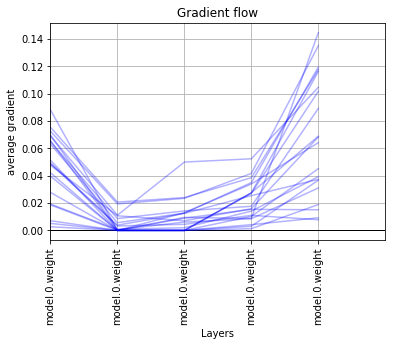

In [355]:
gnn = GNBlock()
optimizer = optim.Adam(gnn.parameters(), lr = 1e-2)

num_props = 1
num_epochs = 20
for epoch in range(num_epochs):
    run_epoch(gnn, optimizer, node_feats, edge_feats, num_props, epoch+1)
plt.show()